In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

import statsmodels.graphics.tsaplots as tsg
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima.arima import auto_arima

In [2]:
df_raw = pd.read_csv('./data/00_original/Lake_Bilancino.csv', sep=',', header=0)

df = df_raw[['Date', 'Rainfall_Cavallina', 'Flow_Rate', 'Lake_Level']].copy()

df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')

df.set_index(['Date'], inplace=True)
df = df.asfreq('D')
df = df.dropna()
print(df.index)

df.loc[:, 'Lake_Level'] -= (251 - 31)

# df = df.resample('W').mean()
# df = df.asfreq('W')
df.head(5)

DatetimeIndex(['2004-01-01', '2004-01-02', '2004-01-03', '2004-01-04',
               '2004-01-05', '2004-01-06', '2004-01-07', '2004-01-08',
               '2004-01-09', '2004-01-10',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='Date', length=6026, freq='D')


,Rainfall_Cavallina,Flow_Rate,Lake_Level
Date,,,
2004-01-01,0.0,0.5,31.14
2004-01-02,0.0,0.5,31.21
2004-01-03,0.0,0.5,31.28
2004-01-04,0.0,0.5,31.35
2004-01-05,0.0,0.5,31.37


In [3]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6026 entries, 2004-01-01 to 2020-06-30
Freq: D
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rainfall_Cavallina  6026 non-null   float64
 1   Flow_Rate           6026 non-null   float64
 2   Lake_Level          6026 non-null   float64
dtypes: float64(3)
memory usage: 188.3 KB


,Rainfall_Cavallina,Flow_Rate,Lake_Level
Date,,,
2004-01-01,0.0,0.5,31.14
2004-01-02,0.0,0.5,31.21
2004-01-03,0.0,0.5,31.28
2004-01-04,0.0,0.5,31.35
2004-01-05,0.0,0.5,31.37


<AxesSubplot:xlabel='Date'>

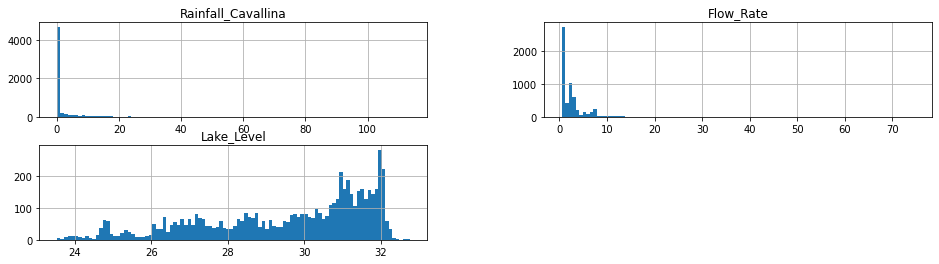

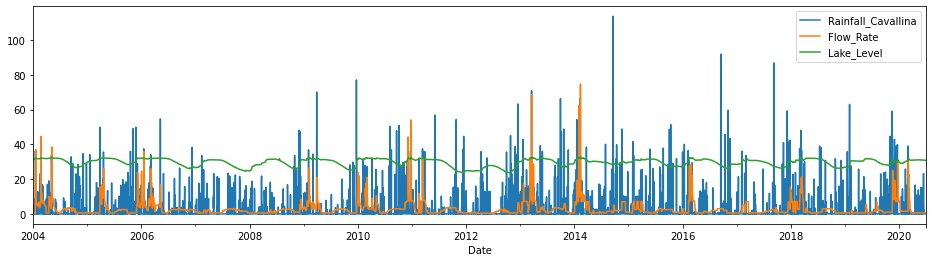

In [4]:
df.hist(figsize=(16, 4), bins=100)
df.plot(figsize=(16, 4))

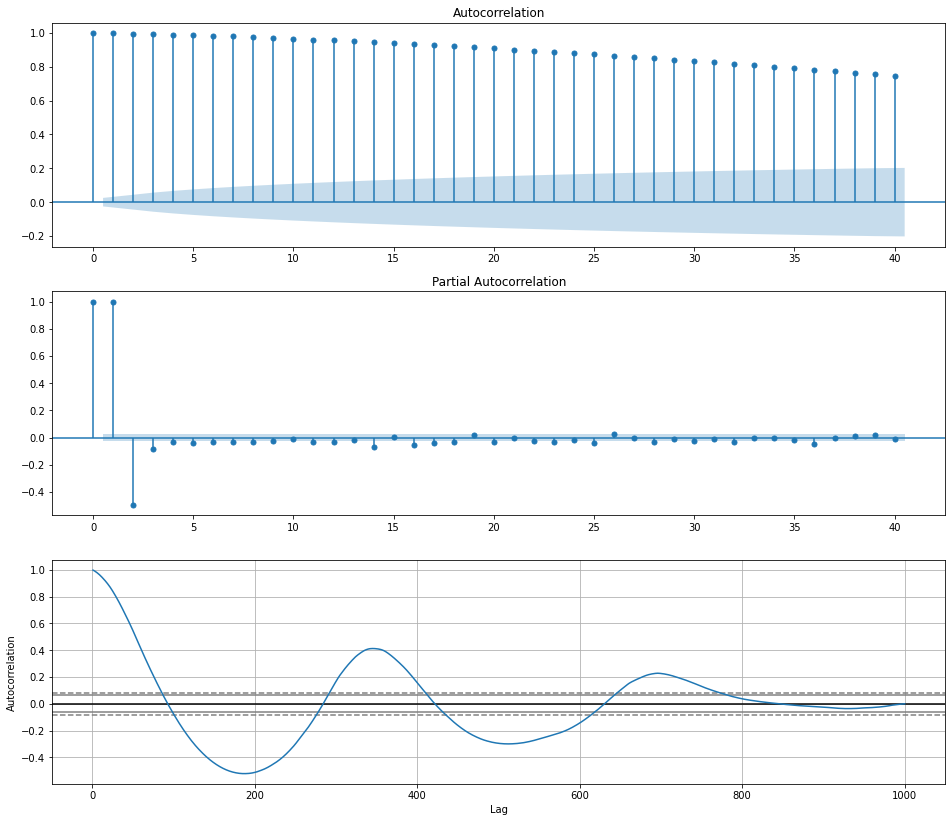

In [5]:
# SEASONALITY CHECK

def seasonality_plot(column):
    fig, ax = plt.subplots(3, 1, figsize=(16, 14))

    tsg.plot_acf(column,lags=40, ax=ax[0])
    tsg.plot_pacf(column,lags=40, ax=ax[1])
    autocorrelation_plot(column[:1000], ax=ax[2])

    plt.show()

seasonality_plot(df['Lake_Level'])

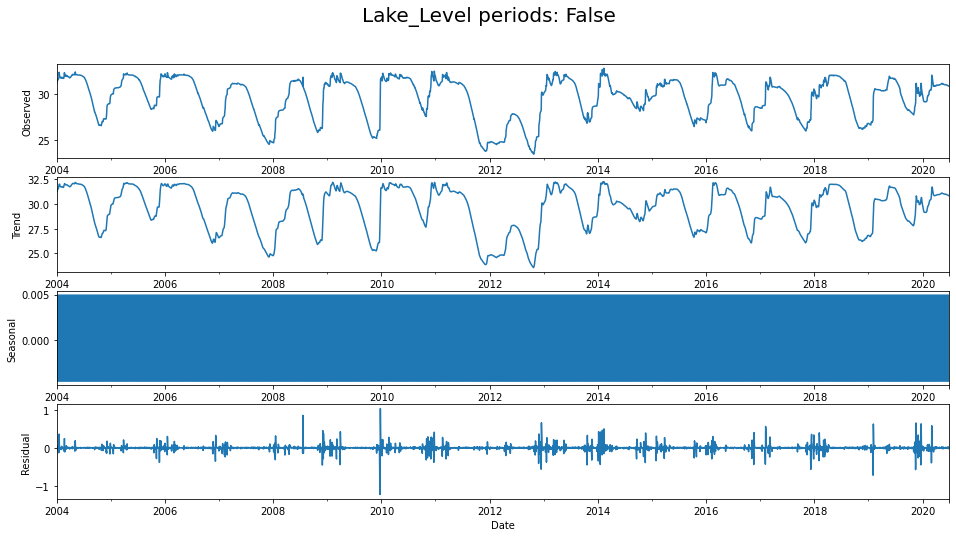

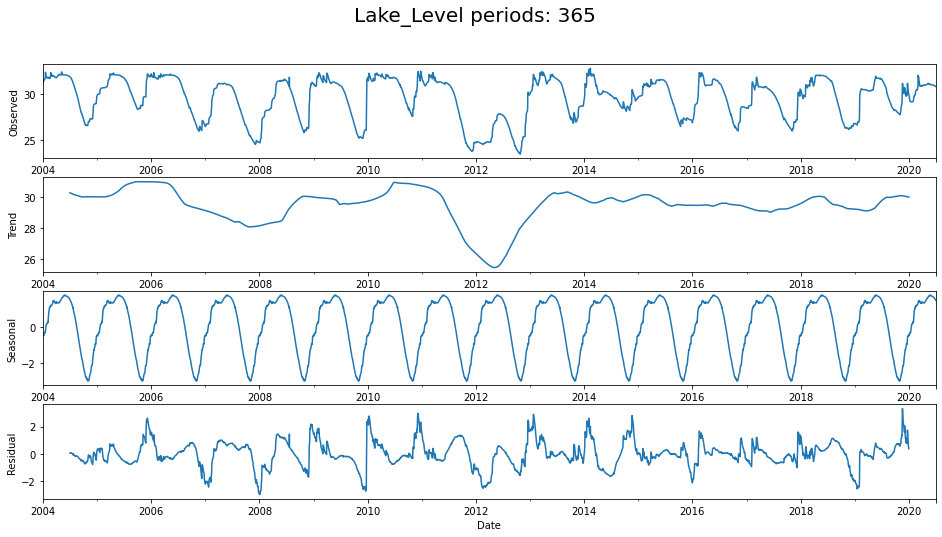

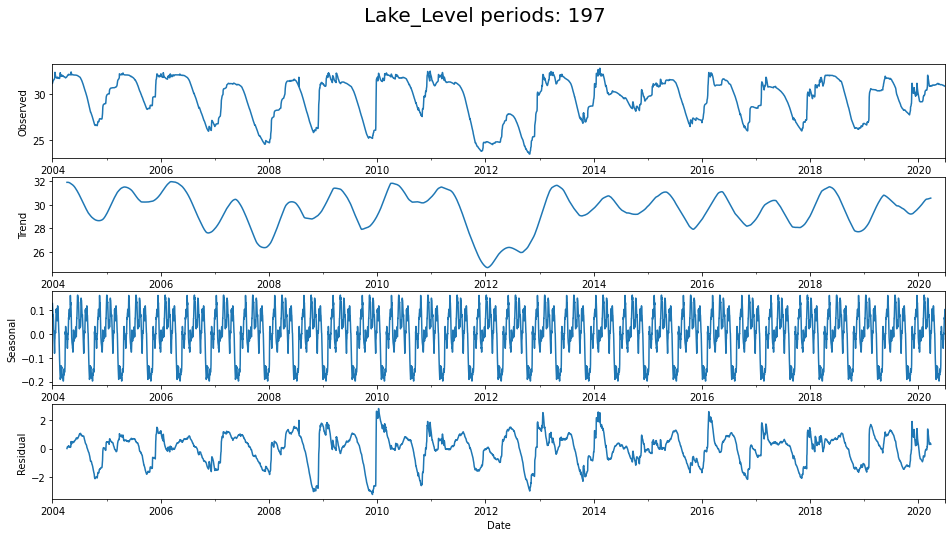

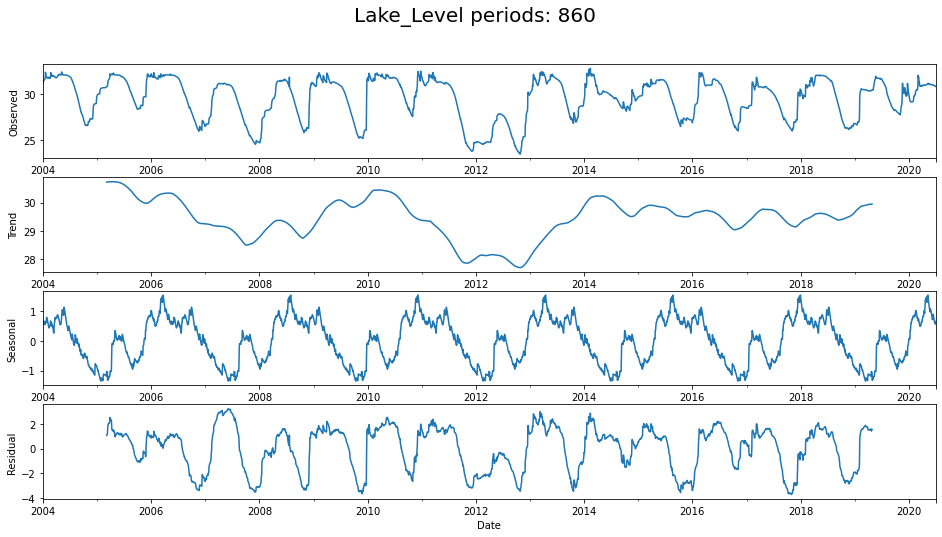

In [6]:
months = int(((max(df.index) - min(df.index)) / np.timedelta64(1, 'M')))
weeks = int(((max(df.index) - min(df.index)) / np.timedelta64(1, 'W')))

def seasonal_decompose_plot(series, period=False):
    
    if period != False:
        result = seasonal_decompose(series, model='additive', period=period)
    else:
        result = seasonal_decompose(series, model='additive', extrapolate_trend='freq')

    fig, ax = plt.subplots(4,1, figsize=(16, 8))
    
    fig.suptitle('{} periods: {}'.format(series.name, period), size=20)

    result.observed.plot(ax=ax[0])
    ax[0].set_ylabel('Observed')
    result.trend.plot(ax=ax[1])
    ax[1].set_ylabel('Trend')
    result.seasonal.plot(ax=ax[2])
    ax[2].set_ylabel('Seasonal')
    result.resid.plot(ax=ax[3])
    ax[3].set_ylabel('Residual')

seasonal_decompose_plot(df['Lake_Level'])
seasonal_decompose_plot(df['Lake_Level'], 365)
seasonal_decompose_plot(df['Lake_Level'], months)
seasonal_decompose_plot(df['Lake_Level'], weeks)

In [7]:
# STATIONARITY
# Stationarity check means that we have constant mean and variance of the data over the time.
# We can inspect visually or use Dickey-Fuller statistical test.

# Dickey-Fuller statisticall test:
# Is trying to reject the null hypothesis that the data is non-stationary.
# If we reject the test means that data is stationary
#    if p <= 0.05 we reject the null hypothesis and data is stationary
#    if p >  0.05 we accept the null hypothesis and data is non-stationary

def testDickeyFuller(series, rolling_interval, visualise=False):
    adf_test_result = sts.adfuller(series.values)
    
    significance_level = 0.05
    adf = adf_test_result[0]
    pValue = adf_test_result[1]
    threshold_1 = adf_test_result[4]['1%']
    threshold_5 = adf_test_result[4]['5%']
    threshold_10 = adf_test_result[4]['10%']
    
    print('\nDickey-Fuller Test for "{}":'.format(series.name))
    print('\t ADF = {}'.format(str(adf)))
    print('\t   p = {}'.format(str(pValue)))
    
    color = 'purple'
    if (pValue < significance_level) & (adf < threshold_1):
        color = 'forestgreen' 
        print('\tdata IS stationary => p < {} & adf < 1%'.format(significance_level))
    elif (pValue < significance_level) & (adf < threshold_5):
        color = 'orange'
        print('\tdata IS stationary => p < {} & adf < 5%'.format(significance_level))
    elif (pValue < significance_level) & (adf < threshold_10):
        color = 'red'
        print('\tdata IS stationary => p < {} & adf < 10%'.format(significance_level))
    else:
        print('\tdata NOT stationary')
    
    if visualise == True:
        fig, ax = plt.subplots(1, 1, figsize=(16, 6.5))

        fig.suptitle('Time Series: {}'.format(series.name), size=20)

        ax.scatter(x=df.index, y=series, color=color, label=series.name, marker='.', s=10, alpha=1)
        ax2 = ax.twinx()

        ax.plot(series.rolling(rolling_interval).mean(), color='red', label='rolling mean {}'.format(rolling_interval))
        ax.plot(series.rolling(rolling_interval).std(), color='purple', label='rolling std {}'.format(rolling_interval))
        fig.legend()

In [8]:

def make_returns(df, columns):    
    for c in columns:
#         df['{}_ret'.format(c)] = df[c].pct_change(1).mul(100) # can causes 0 / 0 = infinity
        df['{}_ret'.format(c)] = df[c].diff()
    df = df.dropna()
    return df

df = make_returns(df, ['Rainfall_Cavallina', 'Flow_Rate', 'Lake_Level'])

for c in df.columns:
    testDickeyFuller(df[c], months, False)


Dickey-Fuller Test for "Rainfall_Cavallina":
	 ADF = -18.902421000932005
	   p = 0.0
	data IS stationary => p < 0.05 & adf < 1%

Dickey-Fuller Test for "Flow_Rate":
	 ADF = -10.089478523900356
	   p = 1.1321317252155166e-17
	data IS stationary => p < 0.05 & adf < 1%

Dickey-Fuller Test for "Lake_Level":
	 ADF = -5.699711266094148
	   p = 7.726366762779989e-07
	data IS stationary => p < 0.05 & adf < 1%

Dickey-Fuller Test for "Rainfall_Cavallina_ret":
	 ADF = -22.15984685956115
	   p = 0.0
	data IS stationary => p < 0.05 & adf < 1%

Dickey-Fuller Test for "Flow_Rate_ret":
	 ADF = -18.84433890211933
	   p = 0.0
	data IS stationary => p < 0.05 & adf < 1%

Dickey-Fuller Test for "Lake_Level_ret":
	 ADF = -11.204606792720012
	   p = 2.2006343703517577e-20
	data IS stationary => p < 0.05 & adf < 1%


            Rainfall_Cavallina  Flow_Rate  Lake_Level  Rainfall_Cavallina_ret  \
Date                                                                            
2016-05-11                 7.4        0.6       30.97                    -5.2   
2016-05-12                 8.6        0.6       31.01                     1.2   
2016-05-13                 1.2        0.6       31.11                    -7.4   
2016-05-14                 2.4        0.6       31.30                     1.2   
2016-05-15                 4.2        0.6       31.40                     1.8   

            Flow_Rate_ret  Lake_Level_ret  
Date                                       
2016-05-11            0.0            0.00  
2016-05-12            0.0            0.04  
2016-05-13            0.0            0.10  
2016-05-14            0.0            0.19  
2016-05-15            0.0            0.10  
            Rainfall_Cavallina  Flow_Rate  Lake_Level  Rainfall_Cavallina_ret  \
Date                                       

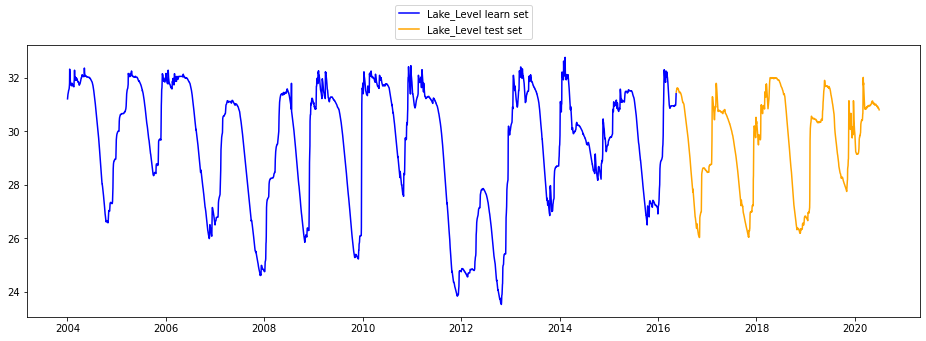

In [9]:
test_percentage = 0.25

split = int(len(df) * (1 - test_percentage))
df_learn = df.iloc[:split]
df_test = df.iloc[split:]

fig, ax = plt.subplots(1, 1, figsize=(16, 5))

ax.plot(df_learn['Lake_Level'], color='blue', label='Lake_Level learn set')
ax.plot(df_test['Lake_Level'], color='orange', label='Lake_Level test set')
fig.legend(loc='upper center');

print(df_learn.tail(5))
print(df_test.head(5))

In [10]:
# model_auto = auto_arima(
#     y = df_learn['Lake_Level_ret'],
#     X = df_learn[['Rainfall_Cavallina', 'Flow_Rate']],
#     seasonal=True,
#     stationary=True,
#     alpha=0.05,
#     stepwise=True
# )

# model_auto.summary()

In [15]:
df_learn.head(5)

,Rainfall_Cavallina,Flow_Rate,Lake_Level,Rainfall_Cavallina_ret,Flow_Rate_ret,Lake_Level_ret
Date,,,,,,
2004-01-02,0.0,0.5,31.21,0.0,0.0,0.07
2004-01-03,0.0,0.5,31.28,0.0,0.0,0.07
2004-01-04,0.0,0.5,31.35,0.0,0.0,0.07
2004-01-05,0.0,0.5,31.37,0.0,0.0,0.02
2004-01-06,0.0,0.5,31.42,0.0,0.0,0.05


                               SARIMAX Results                                
Dep. Variable:         Lake_Level_ret   No. Observations:                 4518
Model:               SARIMAX(1, 0, 1)   Log Likelihood                4880.782
Date:                Thu, 11 Feb 2021   AIC                          -9751.565
Time:                        20:52:10   BIC                          -9719.486
Sample:                    01-02-2004   HQIC                         -9740.264
                         - 05-15-2016                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Rainfall_Cavallina_ret    -0.0023   3.47e-05    -67.357      0.000      -0.002      -0.002
Flow_Rate_ret              0.0099      0.000     59.927      0.000       0.010       0.010
ar.L

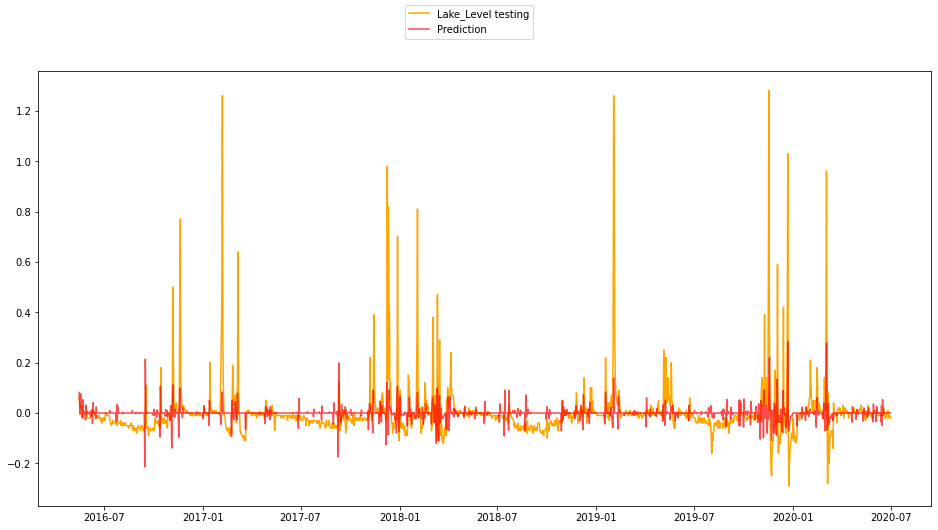

In [40]:
model = SARIMAX(
    df_learn.Lake_Level_ret,
    order=(1, 0, 1),
    season=(1, 0, 1, 365),
    exog = df_learn[['Rainfall_Cavallina', 'Flow_Rate']],
)

model_fit = model.fit()

print(model_fit.summary())

# predictions = model_fit.forecast(
#     steps=len(df_test),
#     exog = df_test[['Rainfall_Cavallina','Flow_Rate']]
# )

start_date=df_test.index[0].strftime('%Y-%m-%d')
end_date=df_test.index[-1].strftime('%Y-%m-%d')
# start_date='2016-05-16'
# end_date='2020-06-30'

predictions = model_fit.predict(
    start=start_date,
    end=end_date,
    dynamic=True,
    exog=df_test[['Rainfall_Cavallina','Flow_Rate']][start_date:end_date]
)

print(predictions)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
# ax.plot(model_fit.fittedvalues[1:], color='blue', label='Lake_Level learning')
ax.plot(df_test['Lake_Level_ret'], color='orange', label='Lake_Level testing')
ax.plot(predictions, color='red', label='Prediction', alpha=0.7)
fig.legend(loc='upper center');